# Environment

In [28]:
import numpy as np  
import pandas as pd
from numpy import median, percentile
from numpy.random import seed, randint
 
from sklearn import metrics
#from scipy.integrate import cumtrapz
from sklearn.metrics import (roc_auc_score, cohen_kappa_score,confusion_matrix, precision_score,
                             accuracy_score, average_precision_score, f1_score,
                             precision_recall_curve, roc_curve) #, auc, recall_score)
import matplotlib.pyplot as pyplot              
from inspect import signature
import joblib
from sklearn.calibration import (CalibratedClassifierCV, 
                                 _CalibratedClassifier, calibration_curve)  
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (make_scorer, roc_auc_score) #, cohen_kappa_score,confusion_matrix, precision_score,
#                             accuracy_score, auc, average_precision_score, f1_score,
#                             precision_recall_curve, recall_score, roc_curve)          
import dill
import sys
from xgboost import XGBClassifier

## Import Data

In [29]:
train = pd.read_csv("../../data/train_outsidecpb.csv", delimiter=",", low_memory=False) # ../../ go two folders back from current location

test = pd.read_csv("../../data/test_outsidecpb.csv", delimiter=",", low_memory=False)


cols = ['entropy','duration_Surgery_min','duration_CPB_min',
                              'STS_RiskAlgorithm_median_imp','STS_RiskAlgorithm',
                              'Q_total_pressors_formula_mg','Cross_Clamp_Time_imp', # we don't hace crossclam outside cpb (REMEMBER THIS WHEN RUNNING preCPB AND postCPB)
                              'T_STS_RiskAlgorithm_median_imp','T_STS_RiskAlgorithm_multiple_imp',
                              'Q_AUC65MAP_total_mmHgmin','Q_TWA65MAP_total_mmHg',
                              'Q_AUC65MAP_CPB_mmHgmin', 'Q_AUC65MAP_outsideCPB_mmHgmin',
                              'Q_TWA65MAP_outsideCPB_mmHg', 'Q_TWA65MAP_CPB_mmHg',
                              'TWA65MAP_total_mmHg','TWA65MAP_CPB_mmHg','TWA65MAP_outsideCPB_mmHg',
                              'AUC65MAP_total_mmHgmin', 'AUC65MAP_CPB_mmHgmin',
                              'Any_MAE', 'Stroke', 'RFDS', 'RFD', 'DS', 'RFS', 'id']


train = train.drop(columns = cols)
test = test.drop(columns = cols)

# Converting categorical variables to numeric

train.Gender.loc[train.Gender == 'Male'] = 0 
train.Gender.loc[train.Gender == 'Female'] = 1 
 
train.Category.loc[train.Category == 'Valve'] = 0 
train.Category.loc[train.Category == 'CABG'] = 1 
train.Category.loc[train.Category == 'CABG + Valve'] = 2 
train.Category.loc[train.Category == 'Aortic Surgery'] = 3 
train.Category.loc[train.Category == 'Other'] = 4

test.Gender.loc[test.Gender == 'Male'] = 0 
test.Gender.loc[test.Gender == 'Female'] = 1 
 
test.Category.loc[test.Category == 'Valve'] = 0 
test.Category.loc[test.Category == 'CABG'] = 1 
test.Category.loc[test.Category == 'CABG + Valve'] = 2 
test.Category.loc[test.Category == 'Aortic Surgery'] = 3 
test.Category.loc[test.Category == 'Other'] = 4

# since we are not competing again STS risk score now I did not exclude patients with no STS risk score but I impute the missing values.

# Removing rows based on data availability
#train = train[train['STS_RiskAlgorithm'].notna()]
#test = test[test['STS_RiskAlgorithm'].notna()]

C:\Users\miguel\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [30]:
print(train.shape[0]+test.shape[0])
print(list(train.columns))

5015
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '15

# Split data into x y training and x y test sets

In [31]:
y_train = train['Death']
X_train = train.drop(columns = ['Death'])
    
y_test = test['Death']
X_test = test.drop(columns = ['Death'])

# All    

X_num = X_train.drop(columns = ['Gender','Category','Renal_Failure'])

get_numeric_data = FunctionTransformer(lambda x: x[X_num.columns], validate=False)

get_categorical = FunctionTransformer(lambda x: x[['Gender','Category','Renal_Failure']], validate=False) 

scaler = MinMaxScaler()

# Modeling

In [32]:
# Logistic Regression
lr = LogisticRegression(random_state = 42,tol=1**-4,verbose=1) #,solver='lbfgs') #,class_weight='balanced')

# Random forests
rf = RandomForestClassifier(random_state = 42
                            #,n_jobs =-1 # set The number of jobs to run in parallel -1 means using all processors
                           )

# Neural Network

nn = MLPClassifier(random_state = 42,max_iter=500)

# SVM

svm = SVC(random_state = 42,probability=True) # Whether to enable probability estimates. This must be enabled prior to calling fit, and will slow down that method.

# XGB

xgb = XGBClassifier(random_state = 42)

all_models_list = [lr,
                   rf,
                   nn,
                   svm,
                   xgb]

all_models_names = ['lr',
                    'rf',
                    'nn',
                    'svm',
                    'xgb']

#all_models_list = [rf]

#all_models_names = ['rf']

# Pipelines

These are the parameters we are going to pass to each model in the hyper-parameter tunning.

In [33]:
num_pipe = Pipeline([
  ('select_num', get_numeric_data),
  ('scale', scaler)
  ])

cat_pipe = Pipeline([
  ('select_cat', get_categorical)
  ])

# Logistic Regression
lr_params =  {'clf__C':[0.0001,0.001,0.01,0.1,1.0]
               , 'clf__solver':['newton-cg', 'lbfgs', 'sag', 'saga']
               , 'clf__warm_start':[True,False]}   

# Random forests      
rf_params =  {'clf__n_estimators':  [1000,1500],
               'clf__max_features': ['sqrt'],
               'clf__max_depth': [2,3,4,5],
               'clf__bootstrap': [True, False],
               'clf__criterion': ["gini"],
               'clf__warm_start':[True,False]
               #,'clf__oob_score':[True,False]
             }

# Neural Network    
nn_params =  {'clf__hidden_layer_sizes': [(10,10,10), (50,100,50), (100,20)],
               'clf__activation': ['tanh', 'relu'],
               'clf__solver': ['sgd', 'adam'],
               'clf__alpha': [0.0001, 0.05],
               'clf__learning_rate': ['constant','adaptive']}

# SVM    
svm_params =  {'clf__C': [1, 10, 100, 1000],
               'clf__gamma': [0.001, 0.0001],
               'clf__kernel': ['rbf','linear']} 

# XGB    
xgb_params =  {'clf__max_depth': [1,3,100],
               'clf__learning_rate': [0.1],
               'clf__n_estimators': [100,500,1000],
               'clf__silent': [True],
               'clf__objective': ['binary:logistic'],
               'clf__booster': ['gbtree'],
               'clf__n_jobs': [1],
               'clf__nthread': [None],
               'clf__gamma': [0],
               'clf__min_child_weight': [1],
               'clf__max_delta_step': [0],
               'clf__subsample': [1],
               'clf__colsample_bytree': [1],
               'clf__colsample_bylevel': [1],
               'clf__reg_alpha': [0,0.0001, 0.05, 0.5],
               'clf__reg_lambda': [0,1],
               'clf__scale_pos_weight': [1,53.22], # Controls the balance of positive and negative weights, useful for unbalanced classes. A typical value to consider: sumnegative instances / sumpositive instances
               'clf__base_score': [0.5],
               'clf__random_state': [0],
               'clf__seed': [None]} 

all_params_list = [lr_params,
                    rf_params,
                    nn_params,
                    svm_params,
                    xgb_params
                  ]

#all_params_list = [rf_params
#                  ]

# Scoring

In [34]:
bestmodels = [] # we create an empty list to store the best performing version of each model

if len(all_models_list) == len(all_params_list):
    for i,model in enumerate(all_models_list):
        print(type(all_models_list[i]))
        full_pipeline = Pipeline([('feat_union',
                                   FeatureUnion(transformer_list=[('cat_pipeline', cat_pipe),('num_pipeline', num_pipe) ])),
                                  ('clf', model)])
    
        scoring = make_scorer(roc_auc_score, needs_threshold = True)
    
        random_search = RandomizedSearchCV(full_pipeline, param_distributions=all_params_list[i], n_iter=10, cv=10, refit = True, scoring=scoring, n_jobs=-1, verbose=10, random_state = 42)
    
        sys.setrecursionlimit(10000)
        random_search.fit(X_train, y_train) 
    
        # Best model in training
        bestmodels.append(random_search.best_estimator_)
    
else:
    print('Make sure the amount of models in all_models_list matches the amount of params in all_params_list')

<class 'sklearn.linear_model.logistic.LogisticRegression'>
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  80 out of 100 | elapsed:   23.2s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done  91 out of 100 | elapsed:   24.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


<class 'sklearn.ensemble.forest.RandomForestClassifier'>
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  80 out of 100 | elapsed:  1.9min remaining:   28.1s
[Parallel(n_jobs=-1)]: Done  91 out of 100 | elapsed:  2.0min remaining:   11.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished


<class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  80 out of 100 | elapsed:  5.5min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  91 out of 100 | elapsed:  6.4min remaining:   37.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.7min finished


<class 'sklearn.svm.classes.SVC'>
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done  80 out of 100 | elapsed: 12.4min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  91 out of 100 | elapsed: 13.4min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 13.7min finished


<class 'xgboost.sklearn.XGBClassifier'>
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
C:\Users\miguel\AppData\Local\Continuum\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed: 44.6min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed: 45.7min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 47.2min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed: 53.0min
[Parallel(n_jobs=-1)]: Done  80 out of 100 | elapsed: 57.9min remaining: 14.5min
[Parallel(n_jobs=-1)]: Done  91 out of 100 | elapsed: 61.2min remaining:  6.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 62.0min finished


# Defining functions

## Specificity and Sensitivity

In [43]:
def spec(y_true,y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true,y_pred).ravel()
    return TN/(TN+FP)   

def sens(y_true,y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true,y_pred).ravel()
    return TP/(TP+FN)   

## Optimal AUC threshold

In [44]:
def optimal_threshold_auc(target, predicted):
 
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    return list(roc_t['threshold'])

## AUROC

In [45]:
def auroc(y, ypred,title):
    fig = pyplot.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    fpr, tpr, thresholds = roc_curve(y, ypred)
    auc_score = roc_auc_score(y, ypred)

    pyplot.plot([0, 1], [0, 1], linestyle='--')
    pyplot.plot(fpr, tpr, marker='.',color='c')
    pyplot.xlabel('False positive rate')
    pyplot.ylabel('Recall')
    pyplot.ylim([0.0, 1.05])
    pyplot.xlim([0.0, 1.0])
    pyplot.title(title+' '+'AUROC={0:0.2f}'.format(auc_score)) 
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)

## AUPR  

In [46]:
def aupr(y, ypred,title):
    fig = pyplot.figure(figsize=(8,5))
    ax = fig.add_subplot(111)

    Baseline = sum(y)/len(y)
    average_precision = metrics.average_precision_score(y, ypred)
    
    precision, recall, _ = precision_recall_curve(y, ypred)
    auc = metrics.auc(recall, precision)
    step_kwargs = ({'step': 'post'}
    if 'step' in signature(pyplot.fill_between).parameters
    else {})
    pyplot.step(recall, precision, color='c', where='post')
    pyplot.fill_between(recall, precision, color='c', **step_kwargs)
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.ylim([0.0, 1.05])
    pyplot.xlim([0.0, 1.0])
    pyplot.title(title+' '+'AUPRC={0:0.2f}'.format(auc))
#    pyplot.plot(Baseline, 'b-',label='Baseline')
#    pyplot.legend(bbox_to_anchor=(0.7, 0.9), loc=2, borderaxespad=0., fontsize = 16)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20) 
        
        
def metric_aupr(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    auc = metrics.auc(recall, precision)
    return auc        

## Bootstrapping function

In [47]:
def metric_SMR(y_true, y_pred):
   SMR = sum(y_pred)/sum(y_true)
   return SMR

def get_CI_boot(y_true,y_pred,metric,boot):
    # bootstrap confidence intervals
    # seed the random number generator
    seed(1)
    i = 0
    # generate dataset
    dataset = y_pred
    real = y_true
    # bootstrap
    scores = list()
    while i < boot:
        # bootstrap sample
        indices = randint(0, len(y_pred) - 1, len(y_pred))
        sample = dataset[indices]
        real = y_true[indices]
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue
    	# calculate and store statistic 
        else:
            statistic = metric(real,sample)
            scores.append(statistic)
            i += 1
    
    # calculate 95% confidence intervals (100 - alpha)
    alpha = 5.0
    # calculate lower percentile (e.g. 2.5)
    lower_p = alpha / 2.0
    # retrieve observation at lower percentile
    lower = max(0.0, percentile(scores, lower_p))
    # calculate upper percentile (e.g. 97.5)
    upper_p = (100 - alpha) + (alpha / 2.0)
    # retrieve observation at upper percentile
    if metric == metric_SMR:
        upper = percentile(scores, upper_p)
    else:
        upper = min(1.0, percentile(scores, upper_p))
    delta = upper-lower
    mediana = median(scores)
    return mediana,(lower,upper),delta

# Predictions in train and test

## Insights, AUPR and AUROC curves

lr
[roc_auc_score 0.79 CI [0.69-0.87], precision_score 0.15 CI [0.09-0.31], spec 0.81 CI [0.78-0.83], sens 0.68 CI [0.49-0.86]]
rf
[roc_auc_score 0.83 CI [0.75-0.91], precision_score 0.11 CI [0.06-0.21], spec 0.84 CI [0.81-0.86], sens 0.71 CI [0.54-0.89]]
nn
[roc_auc_score 0.76 CI [0.67-0.86], precision_score 0.08 CI [0.05-0.16], spec 0.94 CI [0.92-0.95], sens 0.36 CI [0.2-0.56]]
svm
[roc_auc_score 0.69 CI [0.59-0.79], precision_score 0.07 CI [0.03-0.15], spec 0.9 CI [0.88-0.91], sens 0.29 CI [0.15-0.43]]
xgb
[roc_auc_score 0.87 CI [0.81-0.93], precision_score 0.26 CI [0.13-0.43], spec 0.85 CI [0.83-0.87], sens 0.71 CI [0.52-0.85]]


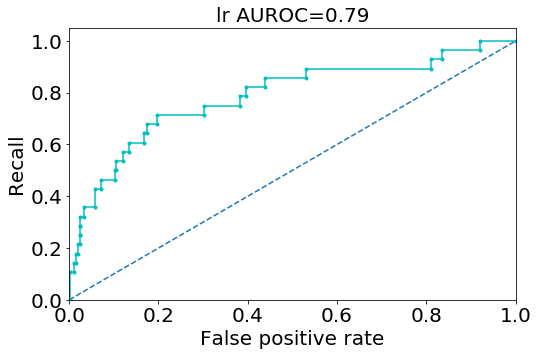

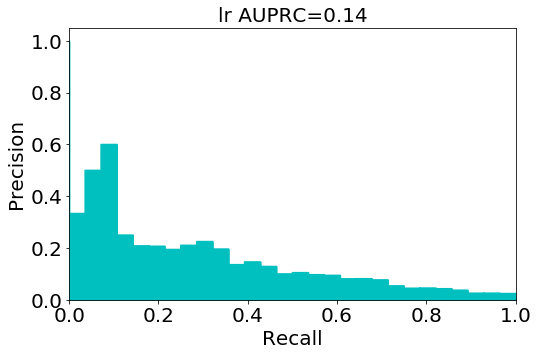

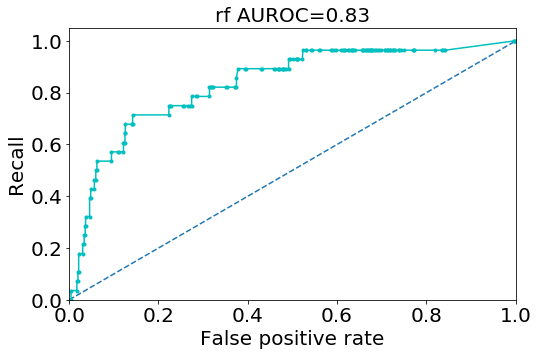

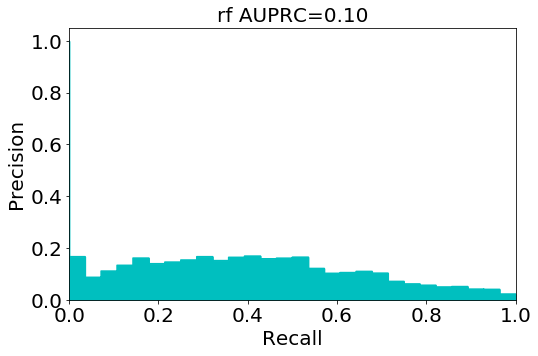

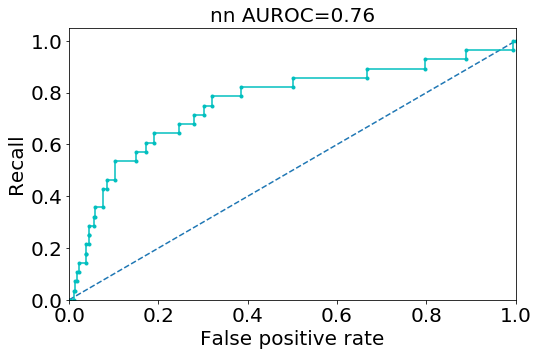

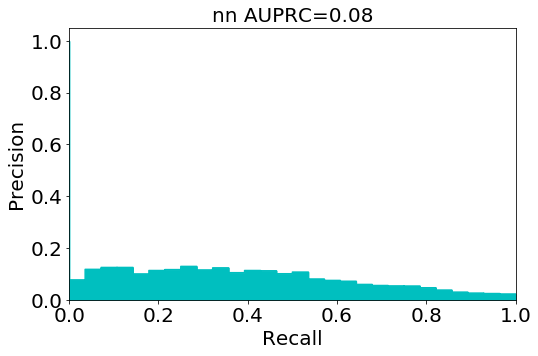

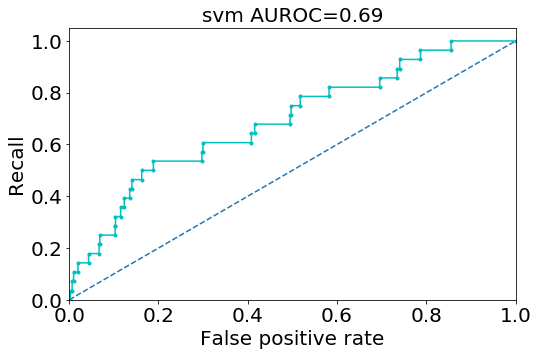

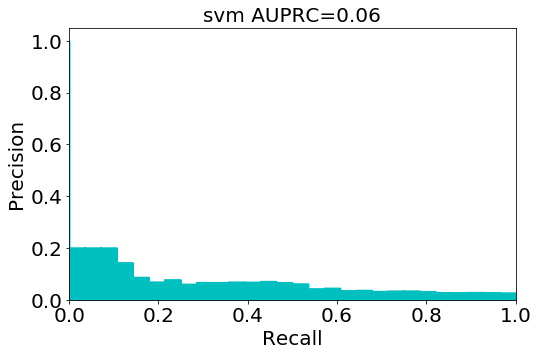

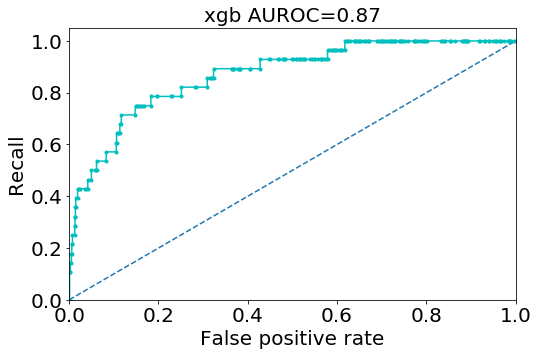

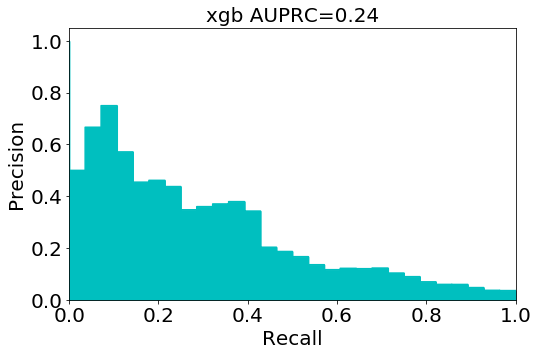

In [48]:
for i,model in enumerate(bestmodels):
    modelname = all_models_names[i]
    print(modelname)
    y_train_pred = model.predict_proba(X_train)[:,1]
    y_test_pred = model.predict_proba(X_test)[:,1]
    auroc(y_test, y_test_pred,all_models_names[i])
    aupr(y_test, y_test_pred,all_models_names[i])
    # Threshold in train
    threshold = optimal_threshold_auc(y_train, y_train_pred)
    
   # performance_all = [roc_auc_score,average_precision_score, accuracy_score, spec, 
   #                sens, precision_score, f1_score, cohen_kappa_score,metric_SMR,metric_aupr] 
   # 
   # performance_names_all = np.array(['roc_auc_score','average_precision_score'
   #                               ,' accuracy_score',' spec','sens',' precision_score'
   #                               ,' f1_score',' cohen_kappa_score','metric_SMR','metric_aupr'])
   # 
    performance = [roc_auc_score,average_precision_score, spec, sens] 
    
    performance_names = np.array(['roc_auc_score','precision_score','spec','sens'])
    
    
    conf = []
    delt = []
    met = []
    med = []
    te = []
    performance_insights = []
    
    y_test = np.array(y_test)
    
    for i,p in enumerate(performance):
        
        if (p == roc_auc_score or p == average_precision_score or p == metric_aupr):
            mediana,extremes,delta = get_CI_boot(y_test,y_test_pred,p,boot=100) #atencao aqui ao boot
            met.append(p)
            conf.append(extremes)
            delt.append(delta)
            med.append(mediana)
            te.append(p(y_test,y_test_pred)) 
            performance_insights.append(performance_names[i]+' '+str(round(p(y_test,y_test_pred), 2)) +' CI ['+ str(round(extremes[0], 2))  +'-'+  str(round(extremes[1], 2)) +']')
        else:
            y_pred_threshold = (y_test_pred >= threshold).astype(np.int)
            mediana,extremes,delta = get_CI_boot(y_test,y_pred_threshold,p,boot=100)
            met.append(p)
            conf.append(extremes)
            delt.append(delta)
            med.append(mediana)
            te.append(p(y_test,y_pred_threshold)) 
            performance_insights.append(performance_names[i]+' '+str(round(p(y_test,y_pred_threshold), 2)) +' CI ['+ str(round(extremes[0], 2))  +'-'+  str(round(extremes[1], 2)) +']')
            
    
    performance_insights =  str(performance_insights)
    performance_insights = performance_insights.replace("'", "")
    print(performance_insights)    


# Calibration

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
C:\Users\miguel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


ValueError: Buffer dtype mismatch, expected 'float' but got 'double'

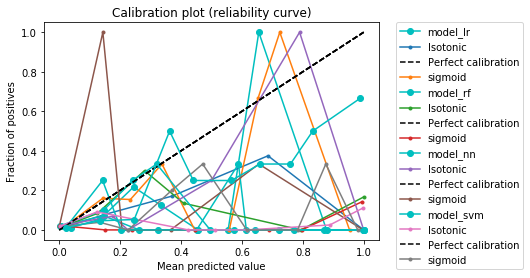

In [49]:
for i,model in enumerate(bestmodels):    
    # Add title and axis names
    pyplot.title('Calibration plot (reliability curve)')
    pyplot.xlabel('Mean predicted value')
    pyplot.ylabel('Fraction of positives')
    
    model.fit(X_train, y_train)
    #y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(np.int)
    prob_pos = model.predict_proba(X_test)[:,1] #).astype(np.int)       
    fraction_of_positives, mean_predicted_value = \
    calibration_curve(y_test, prob_pos, n_bins=10, normalize=True)
    pyplot.plot(mean_predicted_value, fraction_of_positives, 'o-c',label="model_"+all_models_names[i])
    
    pyplot.title('Calibration plot (reliability curve)')
    pyplot.xlabel('Mean predicted value')
    pyplot.ylabel('Fraction of positives')
    
    
    model_isotonic = _CalibratedClassifier(model, method='isotonic')
    model_isotonic.fit(X_train, y_train)
    calibrated = model_isotonic
    # predict probabilities
    probs = calibrated.predict_proba(X_test)[:, 1]
    # reliability diagram
    fop, mpv = calibration_curve(y_test, probs, n_bins=10, normalize=True)
    # plot calibrated reliability
    pyplot.plot(mpv, fop, marker='.',label="Isotonic")
    
    model_isotonic = _CalibratedClassifier(model, method='sigmoid')
    model_isotonic.fit(X_train, y_train)
    calibrated = model_isotonic
    # predict probabilities
    probs = calibrated.predict_proba(X_test)[:, 1]
    # reliability diagram
    fop, mpv = calibration_curve(y_test, probs, n_bins=10, normalize=True)
    pyplot.plot([0, 1], [0, 1], 'k--',label='Perfect calibration')
    # plot calibrated reliability
    pyplot.plot(mpv, fop, marker='.',label="sigmoid")
    
    pyplot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Features Importance

In [59]:
cols_names = list(X_train)

# RF
coef = bestmodels[4].steps[1][1].feature_importances_
coef = np.matrix(coef)
feature_importance = abs(coef)
#intercept = clf.best_estimator_.steps[1][1].intercept_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(np.transpose(feature_importance))
pos = np.arange(sorted_idx.shape[0]) + .5

#np.column_stack([cols_names,list(feature_importance)])

#pd.dataframe.feature_importance


feature_importance_table = pd.DataFrame(feature_importance, columns=cols_names).T # transposing
feature_importance_table.columns = ['Importance']

feature_importance_table.to_csv(path_or_buf='feature_importance_table.csv')

print(feature_importance_table)

#featfig = pyplot.figure(figsize=(15, 15))
#featax = featfig.add_subplot(1, 1, 1)
#featax.barh(pos, feature_importance[sorted_idx], align='center')
#featax.set_yticks(pos)
#featax.set_yticklabels(np.array(cols_names)[sorted_idx], fontsize=18)
#featax.set_xlabel('Relative Feature Importance', fontsize=18)
#
#
#pyplot.tight_layout()
#pyplot.show()

                             Importance
1                              0.000000
2                              0.000000
3                            100.000000
4                              0.000000
5                              0.000000
...                                 ...
total_pressors_formula_mg     94.811130
delta_HCT_pct_median_imp      86.445445
mean_ef_median_imp             0.000000
AUC65MAP_outsideCPB_mmHgmin    0.000000
Renal_Failure                 47.871733

[2439 rows x 1 columns]


# AUROC figures all preCPB ML models

(0.0, 1.0)

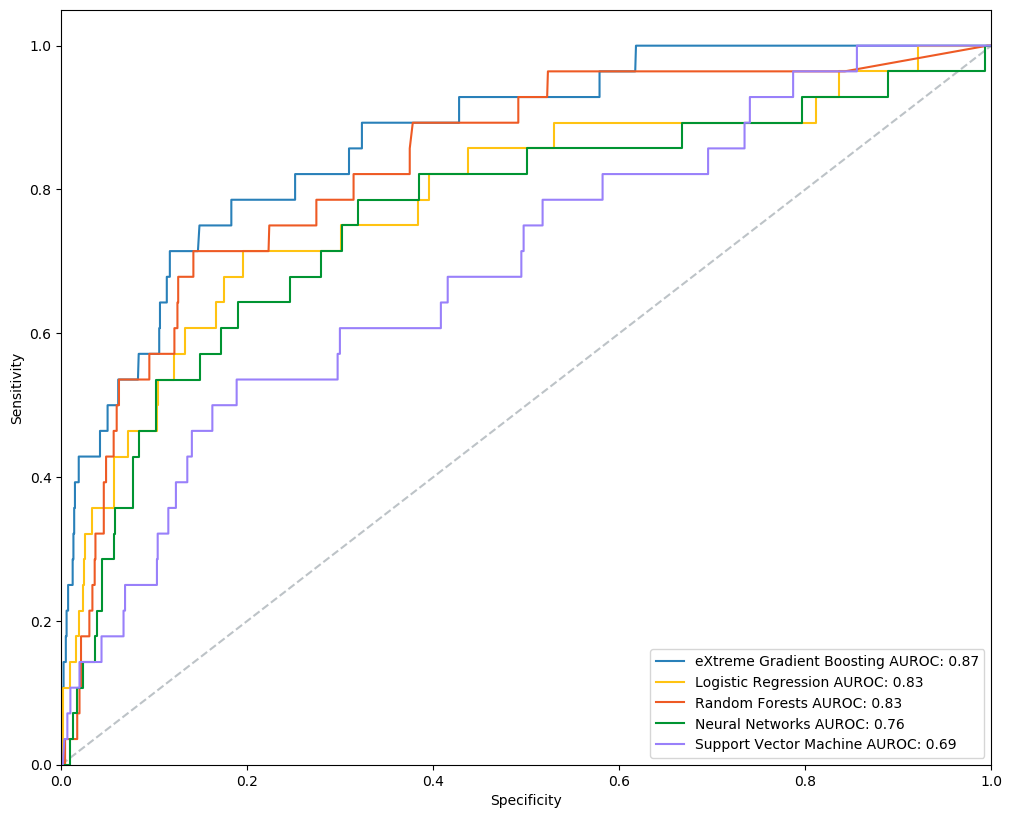

In [75]:
#  model0 prediction
model0 = bestmodels[0] # select the best performing model here
y_train_pred_model0 = model0.predict_proba(X_train)[:,1]
y_test_pred_model0 = model0.predict_proba(X_test)[:,1]
fpr_model0, tpr_model0, thresholds_model0 = roc_curve(y_test, y_test_pred_model0)
auc_score_model0 = roc_auc_score(y_test, y_test_pred_model0)

#  model1 prediction
model1 = bestmodels[1] # select the best performing model here
y_train_pred_model1 = model1.predict_proba(X_train)[:,1]
y_test_pred_model1 = model1.predict_proba(X_test)[:,1]
fpr_model1, tpr_model1, thresholds_model1 = roc_curve(y_test, y_test_pred_model1)
auc_score_model1 = roc_auc_score(y_test, y_test_pred_model1)

#  model2 prediction
model2 = bestmodels[2] # select the best performing model here
y_train_pred_model2 = model2.predict_proba(X_train)[:,1]
y_test_pred_model2 = model2.predict_proba(X_test)[:,1]
fpr_model2, tpr_model2, thresholds_model2 = roc_curve(y_test, y_test_pred_model2)
auc_score_model2 = roc_auc_score(y_test, y_test_pred_model2)

#  model3 prediction
model3 = bestmodels[3] # select the best performing model here
y_train_pred_model3 = model3.predict_proba(X_train)[:,1]
y_test_pred_model3 = model3.predict_proba(X_test)[:,1]
fpr_model3, tpr_model3, thresholds_model3 = roc_curve(y_test, y_test_pred_model3)
auc_score_model3 = roc_auc_score(y_test, y_test_pred_model3)

#  model4 prediction
model4 = bestmodels[4] # select the best performing model here
y_train_pred_model4 = model4.predict_proba(X_train)[:,1]
y_test_pred_model4 = model4.predict_proba(X_test)[:,1]
fpr_model4, tpr_model4, thresholds_model4 = roc_curve(y_test, y_test_pred_model4)
auc_score_model4 = roc_auc_score(y_test, y_test_pred_model4)

my_dpi=100
pyplot.figure(figsize=(1200/my_dpi,1000/my_dpi), dpi=my_dpi)
pyplot.plot([0, 1], [0, 1], linestyle='--', color='#bdc3c7')

#We place the best performing one the first

# AUROC model4
pyplot.plot(fpr_model4, tpr_model4, marker='',color='#2980b9',label='eXtreme Gradient Boosting AUROC:'+' '+'{0:0.2f}'.format(auc_score_model4))

# AUROC model0
pyplot.plot(fpr_model0, tpr_model0, marker='',color='#FFC312',label='Logistic Regression AUROC:'+' '+'{0:0.2f}'.format(auc_score_model1))

# AUROC model1
pyplot.plot(fpr_model1, tpr_model1, marker='',color='#EE5A24',label='Random Forests AUROC:'+' '+'{0:0.2f}'.format(auc_score_model1))

# AUROC model2
pyplot.plot(fpr_model2, tpr_model2, marker='',color='#009432',label='Neural Networks AUROC:'+' '+'{0:0.2f}'.format(auc_score_model2))

# AUROC model3
pyplot.plot(fpr_model3, tpr_model3, marker='',color='#9980FA',label='Support Vector Machine AUROC:'+' '+'{0:0.2f}'.format(auc_score_model3))



pyplot.legend(loc='lower right')
pyplot.xlabel('Specificity')
pyplot.ylabel('Sensitivity')
pyplot.ylim([0.0, 1.05])
pyplot.xlim([0.0, 1.0])


# Save results

In [ ]:
db_name = 'OR'


# LR
model_name = 'LR_AUC'

# RF
model_name = 'RF_AUC'

# MLP
model_name = 'MLP_AUC'

features_name = 'outside_cpb'

features_name = 'outside_cpb'

# Best model
filename = '{}_{}_{}_model.sav'.format(model_name,features_name,db_name)

with open(filename, 'wb') as pickle_file:
    dill.dump(random_search.best_estimator_, pickle_file)
    print('model saved')
    
# CV model
filename = '{}_{}_{}model_CV.sav'.format(model_name,features_name,db_name)

with open(filename, 'wb') as pickle_file:
    dill.dump(random_search, pickle_file)
    print('model saved') 